# Predicción del consumo energético de una vivienda

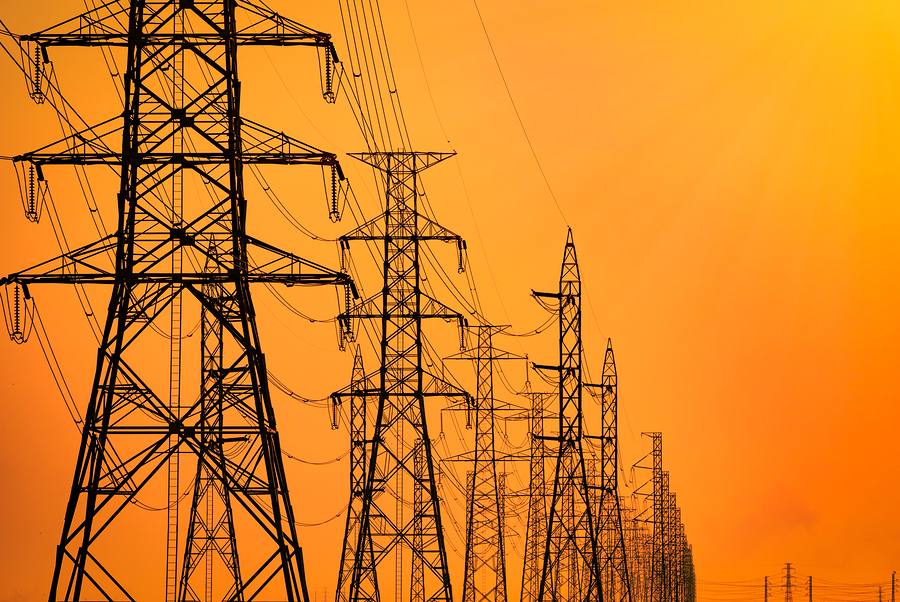

Este archivo contiene 2.075.259 mediciones realizadas en una casa situada en Sceaux (a 7 km de París, Francia) entre diciembre de 2006 y noviembre de 2010 (47 meses).

Contienes las siguientes variables:

1.  date: Fecha en formato dd/mm/aaaa
2.  time: Hora en formato hh:mm:ss
3.  global_active_power: Potencia activa media global por minuto del hogar (en kilovatios)
4.  global_reactive_power: Potencia reactiva media global por minuto del hogar (en kilovatios)
5.  voltage: Tensión media por minuto (en voltios)
6.  global_intensity: Intensidad de corriente media global por minuto del hogar (en amperios)
7.  sub_metering_1: Submedición energética nº 1 (en vatios-hora de energía activa). Corresponde a la cocina, que contiene principalmente un lavavajillas, un horno y un microondas.
8.  sub_metering_2: Submedición energética nº 2 (en vatios-hora de energía activa). Corresponde al lavadero, que contiene una lavadora, una secadora, un frigorífico y una luz.
9.  sub_metering_3: subcontaje de energía nº 3 (en vatios-hora de energía activa). Corresponde a un calentador de agua eléctrico y a un aparato de aire acondicionado.

Notas:

1.  (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) representa la energía activa consumida cada minuto (en vatios hora) en el hogar por equipos eléctricos no medidos en los submedidores 1, 2 y 3.
2. El conjunto de datos contiene algunos valores faltantes en las mediciones (casi el 1,25% de las filas). Todas las marcas de tiempo del calendario están presentes en el conjunto de datos, pero para algunas marcas de tiempo, faltan los valores de las mediciones: un valor faltante se representa por la ausencia de valor entre dos separadores de atributos de punto y coma consecutivos. Por ejemplo, el conjunto de datos muestra valores faltantes el 28 de abril de 2007.

Link a la fuente: https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption



Este ejercicio contempla los siguientes objetivos:


1.   Análisis exploratorio de los datos (missings, autocorrelaciones, estacionalidades...)
2.   Feature enginering (por ejemplo, imputación de missings)
3.   Modelo de predicción para el consumo total (global_active_power). Probar tanto un modelo baseline (como media movil) a uno con alguna técnica mas avanzada.
4.  Evaluación de los modelos probados

Tareas extra de mejora:
1.  Incluir información adicional al modelo (https://www.ncei.noaa.gov/cdo-web/)
2. Plantear un modelo espefícico para el sub_metering_3, que engloba calefacción y aire acondionado
3. Incluir la predicción del consumo global como input del modelo específico





# Loading data:

In [1]:
!pip install ucimlrepo

In [2]:
!pip install pymannkendall

In [3]:
from ucimlrepo import fetch_ucirepo

In [4]:
# imports base
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns

# para calculas métricas del modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# utilidades varias
import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# series temporales
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import het_white
import pymannkendall as mk

from prophet import Prophet
from prophet.plot import plot_cross_validation_metric, plot, plot_components

from pylab import rcParams

rcParams['figure.figsize'] = 15, 12

plt.style.use('seaborn-v0_8')

In [5]:
# fetch dataset
individual_household_electric_power_consumption = fetch_ucirepo(id=235)

# data (as pandas dataframes)
X = individual_household_electric_power_consumption.data.features
y = individual_household_electric_power_consumption.data.targets

# metadata
print(individual_household_electric_power_consumption.metadata)

# variable information
print(individual_household_electric_power_consumption.variables)

{'uci_id': 235, 'name': 'Individual Household Electric Power Consumption', 'repository_url': 'https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption', 'data_url': 'https://archive.ics.uci.edu/static/public/235/data.csv', 'abstract': 'Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.', 'area': 'Physics and Chemistry', 'tasks': ['Regression', 'Clustering'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 2075259, 'num_features': 9, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2006, 'last_updated': 'Fri Mar 08 2024', 'dataset_doi': '10.24432/C58K54', 'creators': ['Georges Hebrail', 'Alice Berard'], 'intro_paper': None, 'additional_info': {'summary': 'This archiv

In [6]:
# fetch dataset
individual_household_electric_power_consumption= fetch_ucirepo(id=235)

In [7]:
# variable information
print(individual_household_electric_power_consumption.variables)

                    name     role         type demographic description units  \
0                   Date  Feature         Date        None        None  None   
1                   Time  Feature  Categorical        None        None  None   
2    Global_active_power  Feature   Continuous        None        None  None   
3  Global_reactive_power  Feature   Continuous        None        None  None   
4                Voltage  Feature   Continuous        None        None  None   
5       Global_intensity  Feature   Continuous        None        None  None   
6         Sub_metering_1  Feature   Continuous        None        None  None   
7         Sub_metering_2  Feature   Continuous        None        None  None   
8         Sub_metering_3  Feature   Continuous        None        None  None   

  missing_values  
0             no  
1             no  
2             no  
3             no  
4             no  
5             no  
6             no  
7             no  
8             no  


In [8]:
power_consumption_df = individual_household_electric_power_consumption.data.features

In [9]:
power_consumption_df

Date      Time Global_active_power Global_reactive_power  \
0        16/12/2006  17:24:00               4.216                 0.418   
1        16/12/2006  17:25:00               5.360                 0.436   
2        16/12/2006  17:26:00               5.374                 0.498   
3        16/12/2006  17:27:00               5.388                 0.502   
4        16/12/2006  17:28:00               3.666                 0.528   
...             ...       ...                 ...                   ...   
2075254  26/11/2010  20:58:00               0.946                   0.0   
2075255  26/11/2010  20:59:00               0.944                   0.0   
2075256  26/11/2010  21:00:00               0.938                   0.0   
2075257  26/11/2010  21:01:00               0.934                   0.0   
2075258  26/11/2010  21:02:00               0.932                   0.0   

         Voltage Global_intensity Sub_metering_1 Sub_metering_2  \
0        234.840           18.400          0.000          1.000   
1        233.630           23.000          0.000          1.000   
2        233.290           23.000          0.000          2.000   
3        233.740           23.000          0.000          1.000   
4        235.680           15.800          0.000          1.000   
...          ...              ...            ...            ...   
2075254   240.43              4.0            0.0            0.0   
2075255    240.0              4.0            0.0            0.0   
2075256   239.82              3.8            0.0            0.0   
2075257    239.7              3.8            0.0            0.0   
2075258   239.55              3.8            0.0            0.0   

         Sub_metering_3  
0                  17.0  
1                  16.0  
2                  17.0  
3                  17.0  
4                  17.0  
...                 ...  
2075254             0.0  
2075255             0.0  
2075256             0.0  
2075257             0.0  
2075258             0.0  

[2075259 rows x 9 columns]

# 1.   Análisis exploratorio de los datos (missings, autocorrelaciones, estacionalidades...)

In [10]:
power_consumption_df.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [11]:
power_consumption_df.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [13]:
# numeric_vars = ['Global_active_power', 'Global_reactive_power',
#         'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2']

# for i in numeric_vars:
#    power_consumption_df[i] = power_consumption_df[i].astype(float)

In [14]:
(power_consumption_df == '?').sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3               0
dtype: int64

In [15]:
power_consumption_df.groupby("Global_active_power")['Global_active_power'].count().sort_values(ascending=False)

Global_active_power
?        25979
0.218     9491
0.216     9319
0.322     9226
0.324     9153
         ...  
5.74         1
5.742        1
5.746        1
5.748        1
0.21         1
Name: Global_active_power, Length: 6534, dtype: int64

In [16]:
power_consumption_df.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [17]:
power_consumption_df.replace(['?', 'nan'], np.nan, inplace=True)

In [18]:
numeric_vars = ['Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

for i in numeric_vars:
  power_consumption_df[i] = power_consumption_df[i].astype(float)

In [19]:
power_consumption_df.dtypes

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [20]:
power_consumption_df['DateTime'] = power_consumption_df['Date'].str.cat(power_consumption_df['Time'].values,sep=' ')

In [21]:
power_consumption_df.head()

Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   
2  16/12/2006  17:26:00                5.374                  0.498   233.29   
3  16/12/2006  17:27:00                5.388                  0.502   233.74   
4  16/12/2006  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
0              18.4             0.0             1.0            17.0   
1              23.0             0.0             1.0            16.0   
2              23.0             0.0             2.0            17.0   
3              23.0             0.0             1.0            17.0   
4              15.8             0.0             1.0            17.0   

              DateTime  
0  16/12/2006 17:24:00  
1  16/12/2006 17:25:00  
2  16/12/2006 17:26:00  
3  16/12/2006 17:27:00  
4  16/12/2006 17:28:00

In [22]:
power_consumption_df['DateTime'] = pd.to_datetime(power_consumption_df['DateTime'], format='%d/%m/%Y %H:%M:%S')
power_consumption_df['Date'] = pd.to_datetime(power_consumption_df['Date'], format='%d/%m/%Y')
power_consumption_df['Time'] = pd.to_datetime(power_consumption_df['Time'], format='%H:%M:%S')

In [23]:
power_consumption_df.dtypes

Date                     datetime64[ns]
Time                     datetime64[ns]
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
DateTime                 datetime64[ns]
dtype: object

In [24]:
power_consumption_df.index = power_consumption_df['DateTime']

In [25]:
power_consumption_df.head()

Date                Time  Global_active_power  \
DateTime                                                                  
2006-12-16 17:24:00 2006-12-16 1900-01-01 17:24:00                4.216   
2006-12-16 17:25:00 2006-12-16 1900-01-01 17:25:00                5.360   
2006-12-16 17:26:00 2006-12-16 1900-01-01 17:26:00                5.374   
2006-12-16 17:27:00 2006-12-16 1900-01-01 17:27:00                5.388   
2006-12-16 17:28:00 2006-12-16 1900-01-01 17:28:00                3.666   

                     Global_reactive_power  Voltage  Global_intensity  \
DateTime                                                                
2006-12-16 17:24:00                  0.418   234.84              18.4   
2006-12-16 17:25:00                  0.436   233.63              23.0   
2006-12-16 17:26:00                  0.498   233.29              23.0   
2006-12-16 17:27:00                  0.502   233.74              23.0   
2006-12-16 17:28:00                  0.528   235.68              15.8   

                     Sub_metering_1  Sub_metering_2  Sub_metering_3  \
DateTime                                                              
2006-12-16 17:24:00             0.0             1.0            17.0   
2006-12-16 17:25:00             0.0             1.0            16.0   
2006-12-16 17:26:00             0.0             2.0            17.0   
2006-12-16 17:27:00             0.0             1.0            17.0   
2006-12-16 17:28:00             0.0             1.0            17.0   

                               DateTime  
DateTime                                 
2006-12-16 17:24:00 2006-12-16 17:24:00  
2006-12-16 17:25:00 2006-12-16 17:25:00  
2006-12-16 17:26:00 2006-12-16 17:26:00  
2006-12-16 17:27:00 2006-12-16 17:27:00  
2006-12-16 17:28:00 2006-12-16 17:28:00

In [26]:
power_consumption_df.describe()

Date                           Time  \
count                        2075259                        2075259   
mean   2008-12-05 19:13:27.255191040  1900-01-01 11:59:32.744808704   
min              2006-12-16 00:00:00            1900-01-01 00:00:00   
25%              2007-12-12 00:00:00            1900-01-01 06:00:00   
50%              2008-12-06 00:00:00            1900-01-01 12:00:00   
75%              2009-12-01 00:00:00            1900-01-01 18:00:00   
max              2010-11-26 00:00:00            1900-01-01 23:59:00   
std                              NaN                            NaN   

       Global_active_power  Global_reactive_power       Voltage  \
count         2.049280e+06           2.049280e+06  2.049280e+06   
mean          1.091615e+00           1.237145e-01  2.408399e+02   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.080000e-01           4.800000e-02  2.389900e+02   
50%           6.020000e-01           1.000000e-01  2.410100e+02   
75%           1.528000e+00           1.940000e-01  2.428900e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   
std           1.057294e+00           1.127220e-01  3.239987e+00   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
count      2.049280e+06    2.049280e+06    2.049280e+06    2.049280e+06   
mean       4.627759e+00    1.121923e+00    1.298520e+00    6.458447e+00   
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00   
25%        1.400000e+00    0.000000e+00    0.000000e+00    0.000000e+00   
50%        2.600000e+00    0.000000e+00    0.000000e+00    1.000000e+00   
75%        6.400000e+00    0.000000e+00    1.000000e+00    1.700000e+01   
max        4.840000e+01    8.800000e+01    8.000000e+01    3.100000e+01   
std        4.444396e+00    6.153031e+00    5.822026e+00    8.437154e+00   

                            DateTime  
count                        2075259  
mean   2008-12-06 07:12:59.999994112  
min              2006-12-16 17:24:00  
25%              2007-12-12 00:18:30  
50%              2008-12-06 07:13:00  
75%              2009-12-01 14:07:30  
max              2010-11-26 21:02:00  
std                              NaN

In [27]:
power_consumption_df.isnull().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
DateTime                     0
dtype: int64

In [28]:
power_consumption_df['year'] = power_consumption_df['DateTime'].apply(lambda x: x.year)
power_consumption_df['quarter'] = power_consumption_df['DateTime'].apply(lambda x: x.quarter)
power_consumption_df['month'] = power_consumption_df['DateTime'].apply(lambda x: x.month)
power_consumption_df['day'] = power_consumption_df['DateTime'].apply(lambda x: x.day)

In [29]:
power_consumption_df.head()

Date                Time  Global_active_power  \
DateTime                                                                  
2006-12-16 17:24:00 2006-12-16 1900-01-01 17:24:00                4.216   
2006-12-16 17:25:00 2006-12-16 1900-01-01 17:25:00                5.360   
2006-12-16 17:26:00 2006-12-16 1900-01-01 17:26:00                5.374   
2006-12-16 17:27:00 2006-12-16 1900-01-01 17:27:00                5.388   
2006-12-16 17:28:00 2006-12-16 1900-01-01 17:28:00                3.666   

                     Global_reactive_power  Voltage  Global_intensity  \
DateTime                                                                
2006-12-16 17:24:00                  0.418   234.84              18.4   
2006-12-16 17:25:00                  0.436   233.63              23.0   
2006-12-16 17:26:00                  0.498   233.29              23.0   
2006-12-16 17:27:00                  0.502   233.74              23.0   
2006-12-16 17:28:00                  0.528   235.68              15.8   

                     Sub_metering_1  Sub_metering_2  Sub_metering_3  \
DateTime                                                              
2006-12-16 17:24:00             0.0             1.0            17.0   
2006-12-16 17:25:00             0.0             1.0            16.0   
2006-12-16 17:26:00             0.0             2.0            17.0   
2006-12-16 17:27:00             0.0             1.0            17.0   
2006-12-16 17:28:00             0.0             1.0            17.0   

                               DateTime  year  quarter  month  day  
DateTime                                                            
2006-12-16 17:24:00 2006-12-16 17:24:00  2006        4     12   16  
2006-12-16 17:25:00 2006-12-16 17:25:00  2006        4     12   16  
2006-12-16 17:26:00 2006-12-16 17:26:00  2006        4     12   16  
2006-12-16 17:27:00 2006-12-16 17:27:00  2006        4     12   16  
2006-12-16 17:28:00 2006-12-16 17:28:00  2006        4     12   16

In [30]:
power_consumption_df['Global_active_power'].isna().groupby(power_consumption_df["year"]).sum()

year
2006        4
2007     3931
2008      135
2009     4280
2010    17629
Name: Global_active_power, dtype: int64

In [31]:
power_consumption_df['Global_active_power'].isna().groupby(power_consumption_df["month"]).sum()

month
1     3135
2       71
3     2031
4     3726
5        7
6     3351
7      138
8     8141
9     5242
10      47
11      12
12      78
Name: Global_active_power, dtype: int64

In [32]:
power_consumption_df['Global_active_power'].isna().groupby(power_consumption_df["day"]).sum()

day
1       61
2        2
3        0
4        1
5        0
6        1
7        0
8        0
9       39
10      84
11       2
12     550
13    3749
14    2587
15     586
16       3
17     203
18    1440
19    1442
20    2649
21    2262
22    1291
23       6
24       3
25    1248
26    1445
27    1440
28    2573
29    1443
30     868
31       1
Name: Global_active_power, dtype: int64

In [33]:
power_consumption_df['Global_active_power'].isna().groupby([power_consumption_df['year'],power_consumption_df['month']]).sum()

year  month
2006  12          4
2007  1           2
      2           2
      3           1
      4        3723
      5           0
      6          43
      7         131
      8          22
      9           2
      10          2
      11          2
      12          1
2008  1           1
      2           3
      3           1
      4           0
      5           2
      6           1
      7           2
      8           2
      9           0
      10         43
      11          9
      12         71
2009  1           1
      2          64
      3           2
      4           2
      5           4
      6        3305
      7           4
      8         891
      9           3
      10          1
      11          1
      12          2
2010  1        3131
      2           2
      3        2027
      4           1
      5           1
      6           2
      7           1
      8        7226
      9        5237
      10          1
      11          0
Name: Global_active_power, dtype: int64

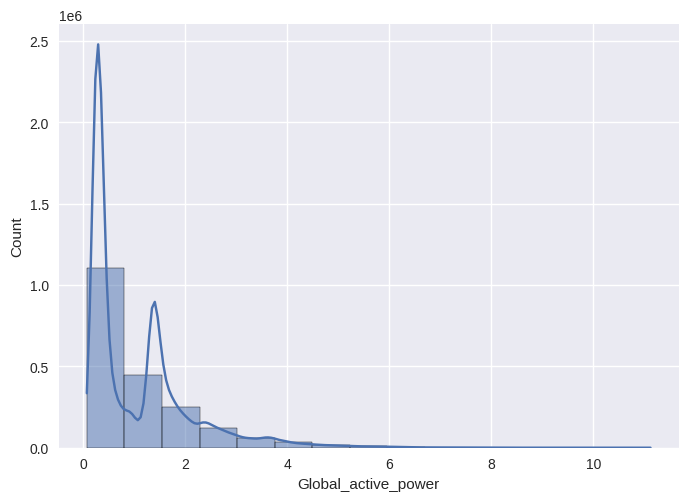

In [34]:
sns.histplot(data=power_consumption_df, x='Global_active_power', bins=15, kde=True)
plt.show()

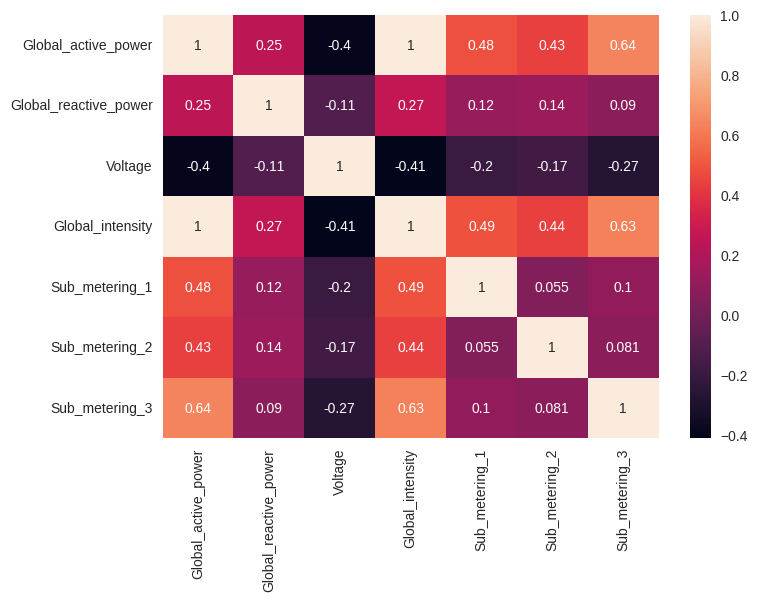

In [35]:
sns.heatmap(power_consumption_df[numeric_vars].corr(), annot=True)
plt.show()

# 2.   Feature enginering (por ejemplo, imputación de missings)

In [36]:
# Opción de imputación a la media:

# for i in numeric_vars:
#         power_consumption_df[i].fillna(power_consumption_df[i].mean(), inplace = True)

In [37]:
# Opcion forward fill:

power_consumption_df = power_consumption_df.ffill()

In [38]:
daily_power_consumption_df = power_consumption_df.groupby(['Date']).Global_active_power.sum().reset_index()

In [39]:
daily_power_consumption_df

Date  Global_active_power
0    2006-12-16             1209.176
1    2006-12-17             3390.460
2    2006-12-18             2203.826
3    2006-12-19             1666.194
4    2006-12-20             2225.748
...         ...                  ...
1437 2010-11-22             2041.536
1438 2010-11-23             1577.536
1439 2010-11-24             1796.248
1440 2010-11-25             1431.164
1441 2010-11-26             1488.104

[1442 rows x 2 columns]

In [40]:
daily_power_consumption_df.dtypes

Date                   datetime64[ns]
Global_active_power           float64
dtype: object

# 3.   Modelo de predicción para el consumo total (global_active_power). Probar tanto un modelo baseline (como media movil) a uno con alguna técnica mas avanzada.

In [41]:
daily_power_consumption_df.columns

Index(['Date', 'Global_active_power'], dtype='object')

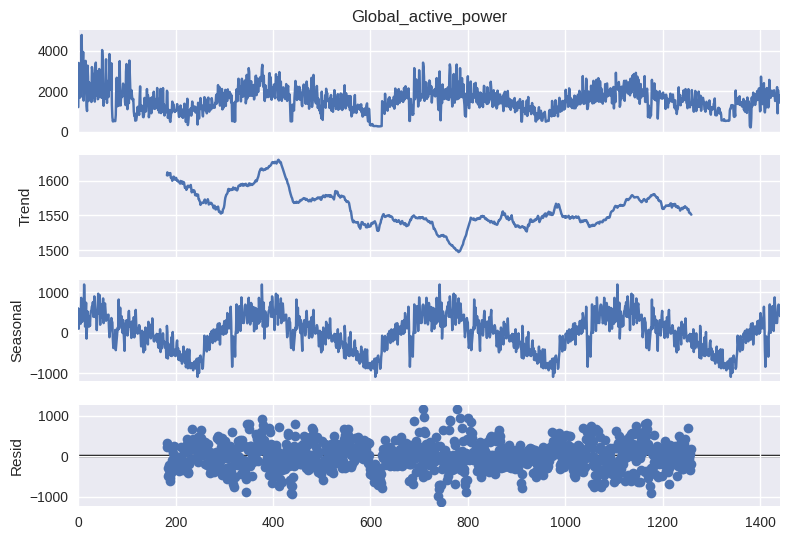

In [42]:
result = seasonal_decompose(daily_power_consumption_df['Global_active_power'], model = 'additive', period=365)
result.plot()
plt.show()

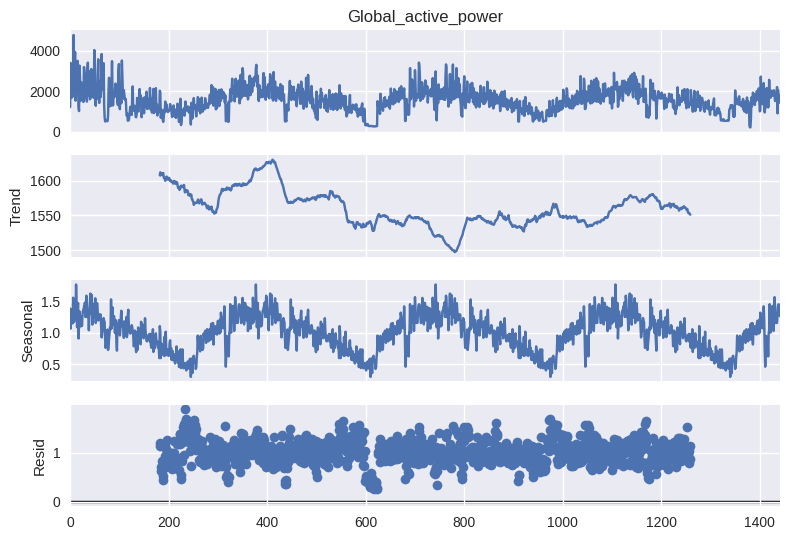

In [43]:
result = seasonal_decompose(daily_power_consumption_df['Global_active_power'], model = 'multiplicative', period=365)
result.plot()
plt.show()

In [44]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller

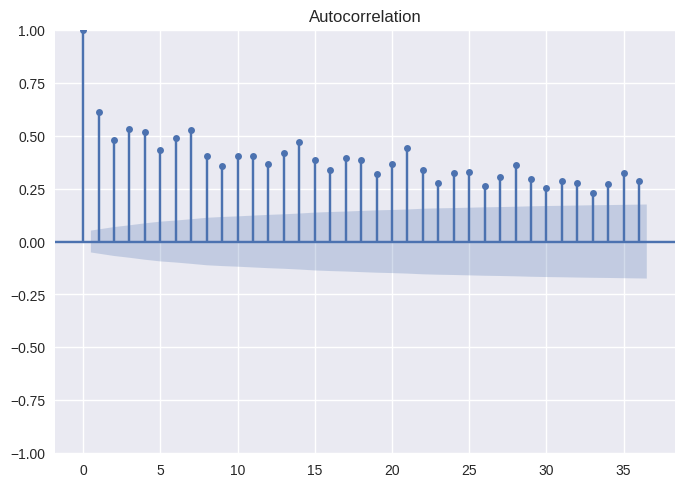

In [45]:
plot_acf(daily_power_consumption_df['Global_active_power'], lags = 36)
plt.show()

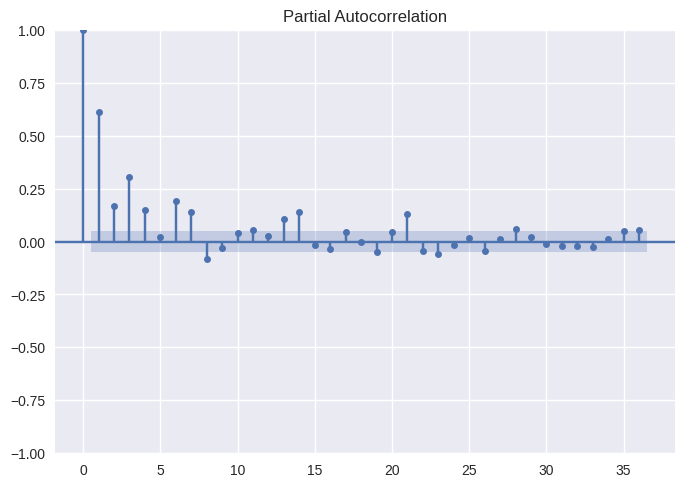

In [46]:
plot_pacf(daily_power_consumption_df['Global_active_power'], lags = 36)
plt.show()

In [47]:
result = adfuller(daily_power_consumption_df['Global_active_power'])
print('p-value of the Dickey-Fuller test: %f' % result[1])

p-value of the Dickey-Fuller test: 0.003344


In [48]:
prophet_df = daily_power_consumption_df[['Global_active_power', 'Date']]
prophet_df = prophet_df.rename(columns = {'Global_active_power':'y', 'Date':'ds'})
prophet_df

y         ds
0     1209.176 2006-12-16
1     3390.460 2006-12-17
2     2203.826 2006-12-18
3     1666.194 2006-12-19
4     2225.748 2006-12-20
...        ...        ...
1437  2041.536 2010-11-22
1438  1577.536 2010-11-23
1439  1796.248 2010-11-24
1440  1431.164 2010-11-25
1441  1488.104 2010-11-26

[1442 rows x 2 columns]

In [49]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 9.4 MB/s eta 0:00:00


In [50]:
from sktime.forecasting.model_selection import temporal_train_test_split

In [51]:
train_df, test_df = temporal_train_test_split(prophet_df, test_size=365)
display(train_df.shape, train_df.head(2), train_df.tail(2))
display(test_df.shape, test_df.head(2), test_df.tail(2))

(1077, 2)

y         ds
0  1209.176 2006-12-16
1  3390.460 2006-12-17

y         ds
1075  1980.130 2009-11-25
1076  1599.626 2009-11-26

(365, 2)

y         ds
1077  1380.026 2009-11-27
1078  1858.950 2009-11-28

y         ds
1440  1431.164 2010-11-25
1441  1488.104 2010-11-26

In [52]:
m = Prophet()
m.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprb3jj3tk/8stlo_rv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprb3jj3tk/t6gdmpvk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92108', 'data', 'file=/tmp/tmprb3jj3tk/8stlo_rv.json', 'init=/tmp/tmprb3jj3tk/t6gdmpvk.json', 'output', 'file=/tmp/tmprb3jj3tk/prophet_model52vm7fwp/prophet_model-20241215095822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:58:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:58:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [53]:
future_df = m.make_future_dataframe(periods=365, freq='D')
future_df

ds
0    2006-12-16
1    2006-12-17
2    2006-12-18
3    2006-12-19
4    2006-12-20
...         ...
1437 2010-11-22
1438 2010-11-23
1439 2010-11-24
1440 2010-11-25
1441 2010-11-26

[1442 rows x 1 columns]

In [54]:
forecast_df = m.predict(future_df)

display(forecast_df.head(5))
display(forecast_df.tail(5))

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2006-12-16  1639.815613  1812.155661  2990.229326  1639.815613  1639.815613   
1 2006-12-17  1639.673219  1858.930952  2972.231847  1639.673219  1639.673219   
2 2006-12-18  1639.530826  1470.851820  2621.273858  1639.530826  1639.530826   
3 2006-12-19  1639.388433  1645.105371  2762.573054  1639.388433  1639.388433   
4 2006-12-20  1639.246040  1617.103598  2791.784960  1639.246040  1639.246040   

   additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0      772.117633            772.117633            772.117633  238.675603   
1      768.992879            768.992879            768.992879  220.722720   
2      402.189575            402.189575            402.189575 -161.715006   
3      555.507403            555.507403            555.507403  -24.375280   
4      576.351628            576.351628            576.351628  -19.375767   

   weekly_lower  weekly_upper      yearly  yearly_lower  yearly_upper  \
0    238.675603    238.675603  533.442031    533.442031    533.442031   
1    220.722720    220.722720  548.270160    548.270160    548.270160   
2   -161.715006   -161.715006  563.904581    563.904581    563.904581   
3    -24.375280    -24.375280  579.882683    579.882683    579.882683   
4    -19.375767    -19.375767  595.727395    595.727395    595.727395   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  2411.933246  
1                         0.0  2408.666099  
2                         0.0  2041.720401  
3                         0.0  2194.895836  
4                         0.0  2215.597668

ds        trend   yhat_lower   yhat_upper  trend_lower  \
1437 2010-11-22  1594.041044  1477.001437  2552.760675  1585.136641   
1438 2010-11-23  1594.122512  1635.288384  2755.374641  1585.172340   
1439 2010-11-24  1594.203979  1619.669757  2744.966098  1585.195392   
1440 2010-11-25  1594.285447  1420.990125  2529.683674  1585.204136   
1441 2010-11-26  1594.366915  1574.337319  2690.067396  1585.245495   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
1437  1603.394309      415.720915            415.720915            415.720915   
1438  1603.506211      562.596836            562.596836            562.596836   
1439  1603.618113      573.270179            573.270179            573.270179   
1440  1603.736605      399.829999            399.829999            399.829999   
1441  1603.857125      534.219062            534.219062            534.219062   

          weekly  weekly_lower  weekly_upper      yearly  yearly_lower  \
1437 -161.715006   -161.715006   -161.715006  577.435921    577.435921   
1438  -24.375280    -24.375280    -24.375280  586.972116    586.972116   
1439  -19.375767    -19.375767    -19.375767  592.645946    592.645946   
1440 -194.834089   -194.834089   -194.834089  594.664087    594.664087   
1441  -59.098181    -59.098181    -59.098181  593.317243    593.317243   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
1437    577.435921                   0.0                         0.0   
1438    586.972116                   0.0                         0.0   
1439    592.645946                   0.0                         0.0   
1440    594.664087                   0.0                         0.0   
1441    593.317243                   0.0                         0.0   

      multiplicative_terms_upper         yhat  
1437                         0.0  2009.761958  
1438                         0.0  2156.719347  
1439                         0.0  2167.474159  
1440                         0.0  1994.115446  
1441                         0.0  2128.585977

In [55]:
forecast_clean = forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_clean

ds         yhat   yhat_lower   yhat_upper
0    2006-12-16  2411.933246  1812.155661  2990.229326
1    2006-12-17  2408.666099  1858.930952  2972.231847
2    2006-12-18  2041.720401  1470.851820  2621.273858
3    2006-12-19  2194.895836  1645.105371  2762.573054
4    2006-12-20  2215.597668  1617.103598  2791.784960
...         ...          ...          ...          ...
1437 2010-11-22  2009.761958  1477.001437  2552.760675
1438 2010-11-23  2156.719347  1635.288384  2755.374641
1439 2010-11-24  2167.474159  1619.669757  2744.966098
1440 2010-11-25  1994.115446  1420.990125  2529.683674
1441 2010-11-26  2128.585977  1574.337319  2690.067396

[1442 rows x 4 columns]

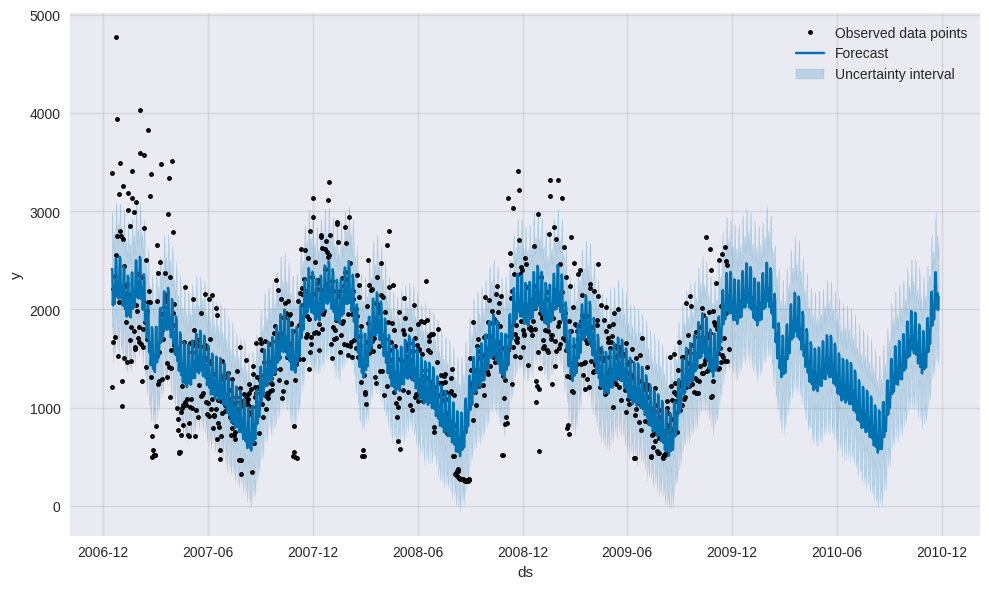

In [56]:
plot_forecast = plot(m, forecast_df, include_legend=True)

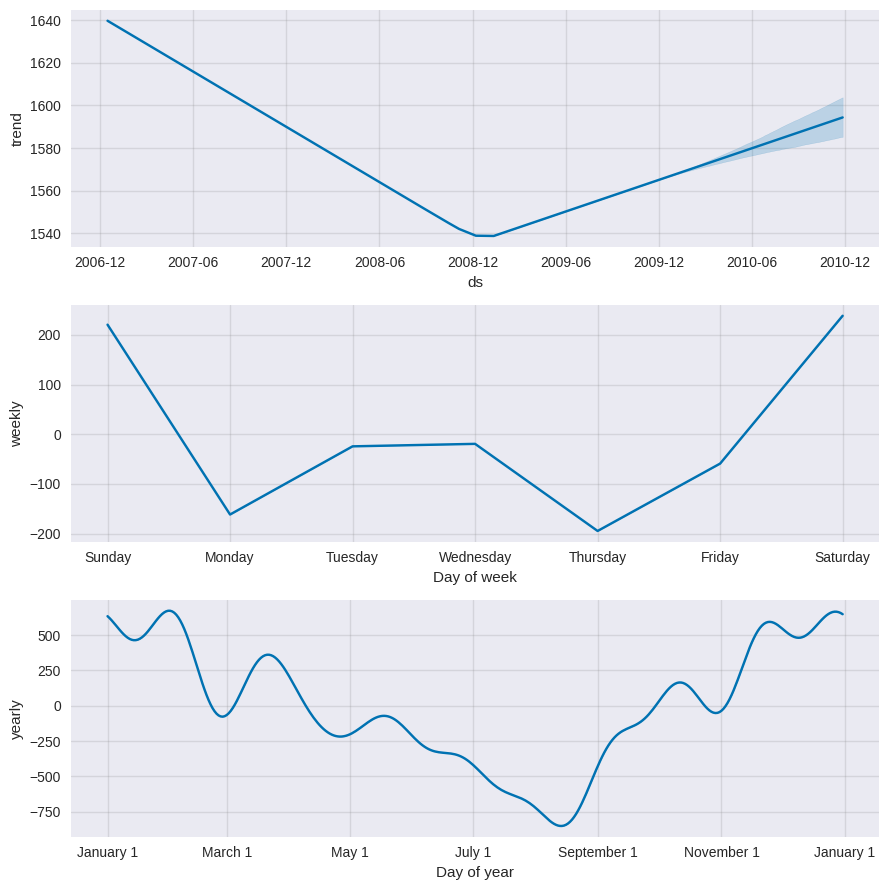

In [57]:
decompose_ = plot_components(m, forecast_df)

# 4.  Evaluación de los modelos probados

In [58]:
full_train_df = pd.merge(train_df, forecast_clean, on='ds', how='left')
full_test_df = pd.merge(test_df, forecast_clean, on='ds', how='left')

In [59]:
full_train_df

y         ds         yhat   yhat_lower   yhat_upper
0     1209.176 2006-12-16  2411.933246  1812.155661  2990.229326
1     3390.460 2006-12-17  2408.666099  1858.930952  2972.231847
2     2203.826 2006-12-18  2041.720401  1470.851820  2621.273858
3     1666.194 2006-12-19  2194.895836  1645.105371  2762.573054
4     2225.748 2006-12-20  2215.597668  1617.103598  2791.784960
...        ...        ...          ...          ...          ...
1072  2450.976 2009-11-22  2365.218022  1752.634942  2930.100691
1073  1471.122 2009-11-23  1991.417865  1422.489158  2579.447140
1074  2128.856 2009-11-24  2133.576175  1614.157159  2685.741925
1075  1980.130 2009-11-25  2139.803697  1582.691010  2738.510947
1076  1599.626 2009-11-26  1962.293194  1380.808140  2532.708284

[1077 rows x 5 columns]

### Error Medio Absoluto (_Mean Absolute Error - MAE_)

In [60]:
mean_absolute_error(y_pred = full_train_df['yhat'], y_true = full_train_df['y'])

332.0747972504159

In [61]:
mean_absolute_error(y_pred = full_test_df['yhat'], y_true = full_test_df['y'])

295.8633298343515

### Error cuadrático medio (_Root Mean Squared Error - RMSE_)

In [62]:
np.sqrt(mean_squared_error(y_pred = full_train_df['yhat'], y_true = full_train_df['y']))

440.7274980865655

In [63]:
np.sqrt(mean_squared_error(y_pred = full_test_df['yhat'], y_true = full_test_df['y']))

401.8825056743038

### Error porcentual absoluto medio (_Mean Absolute Percentage Error - MAPE_)

In [64]:
mean_absolute_percentage_error(y_pred = full_train_df['yhat'], y_true = full_train_df['y'])

0.2888746576792289

In [65]:
mean_absolute_percentage_error(y_pred = full_test_df['yhat'], y_true = full_test_df['y'])

0.2623017134432228